# DIPY Tutorial - Reconstruction of the diffusion signal

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 7.7 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 282 kB 79.1 MB/s eta 0:00:01
     |████████████████████████████████| 120 kB 98.4 MB/s eta 0:00:01
     |████████████████████████████████| 15.3 MB 92.2 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully uninstalled numpy-1.19.4
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an EnvironmentError: [Errno 16] Device or resource busy: '.nfs000000000326435600002709'

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
from dipy.sims.voxel import multi_tensor, multi_tensor_odf
from dipy.data import get_sphere
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere
from dipy.core.gradients import gradient_table

from fury import window, actor
from IPython.core.display import Image
from PIL import Image as PILImage

import os


In [4]:
# helper functions for visualization
WINDOW_SIZE = (400, 400)
SAVEIM_FOLDER = 'images'
if not os.path.exists(SAVEIM_FOLDER):
    os.mkdir(SAVEIM_FOLDER)

def screenshot_animated_sf(sf, sphere, rot=True, norm=True, scale=True, title='Modeling', theta_step=30):
    """
    Render a spherical function to file. Returns path to image.
    """
    scene = window.Scene()
    scene.background(window.colors.white)

    sf_actor = actor.odf_slicer(sf[None, None, None, :],
                                sphere=sphere, colormap='jet',
                                norm=norm, radial_scale=scale)
    if rot :
        sf_actor.RotateX(90)
    scene.add(sf_actor)

    images = []
    n_frames = 360//theta_step
    for i in np.arange(n_frames):
        sf_actor.RotateX(theta_step)
        scene.reset_clipping_range()
        images.append(PILImage.fromarray(window.snapshot(scene, size=WINDOW_SIZE)))
    
    frame_duration = 15000 // theta_step
    filename = os.path.join(SAVEIM_FOLDER, '{0}.gif'.format(title))
    images[0].save(filename, save_all=True, append_images=images[1:],
                   duration=frame_duration, optimize=False, loop=0)
    scene.clear()

    return filename

def screenshot_gradients(sph_gtab, title='Modeling'):
    scene = window.Scene()
    scene.background(window.colors.white)

    scene.add(actor.point(sph_gtab.vertices, window.colors.green, point_radius=0.05))

    outfile = os.path.join(SAVEIM_FOLDER, '{0}.png'.format(title))
    window.snapshot(scene, size=WINDOW_SIZE, fname=outfile)
    
    scene.clear()
    return outfile

# Part 1 - Apparent diffusion coefficient and spherical harmonics

## Generating a gradient table

In [31]:
n_pts = 64
bvalue = 1000
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)

vertices = hsph_updated.vertices
values = np.ones(vertices.shape[0])
bvecs = np.vstack((vertices))
bvals = np.hstack((bvalue * values))
# add some b=0 bvals/bvecs
bvecs = np.insert(bvecs, (0, bvecs.shape[0]), np.array([0, 0, 0]), axis=0)
bvals = np.insert(bvals, (0, bvals.shape[0]), 0)

gtab = gradient_table(bvals, bvecs)
sph_gtab = Sphere(xyz=np.vstack((vertices, -vertices)))

print('bvecs:\n', bvecs)
print('bvals:\n', bvals)

bvecs:
 [[ 0.          0.          0.        ]
 [ 0.05926454  0.9976553   0.03422885]
 [-0.51146359 -0.61652488  0.59858339]
 [-0.4788191   0.20388812  0.85390977]
 [ 0.51960327 -0.29267289  0.80271728]
 [ 0.90715609 -0.20668797  0.36653501]
 [ 0.32575587  0.76028081  0.56201086]
 [-0.10912236  0.93615255  0.33423152]
 [-0.49574561  0.51863533  0.69660153]
 [ 0.99239363 -0.00236798  0.12308243]
 [ 0.82975432 -0.49664471  0.25466018]
 [-0.84906855 -0.29226405  0.44007309]
 [ 0.60481105  0.61355117  0.50769927]
 [ 0.42135749  0.51333857  0.74762382]
 [-0.22863787  0.41230945  0.88188754]
 [ 0.15585309 -0.66533245  0.73009763]
 [ 0.02375726  0.81240388  0.58261095]
 [ 0.12766712 -0.96740011  0.21871932]
 [-0.38031398 -0.92471746  0.01609003]
 [-0.21728851  0.6738622   0.70618372]
 [ 0.89200297  0.09719321  0.44145688]
 [-0.4249835  -0.13206465  0.89551547]
 [-0.18772873  0.08068328  0.97890149]
 [ 0.16449342 -0.03591125  0.98572425]
 [ 0.32663376 -0.81584722  0.4771831 ]
 [ 0.61042464 -0.

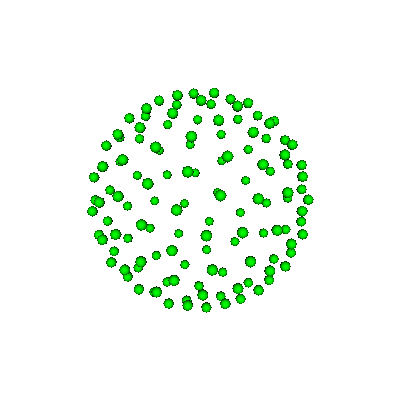

In [32]:
image = screenshot_gradients(sph_gtab, title='Example directions')
Image(filename=image)

For more, see Dipy gallery https://dipy.org/documentation/1.3.0./examples_index/#gradients-spheres.

## Playing with different single and multi-tensor signal generation

In [33]:
S0 = 100
SNR = 100
N = 2 # change this value to try other number of fibers
if N == 1 :
    mevals = np.array([[0.0015, 0.0004, 0.0004]])
    angles = [(0, 0)]
    fractions = [100]
elif N == 2 :
    separation_angle = 90 # play with this parameter to change the angle between fibers
    mevals = np.array([[0.0015, 0.0004, 0.0004],
                       [0.0015, 0.0004, 0.0004]])
    angles = [(0, 0), (separation_angle, 0)]
    fractions = [50, 50]
elif N == 3:
    mevals = np.array([[0.0015, 0.0004, 0.0004],
                       [0.0004, 0.0015, 0.0004],
                       [0.0004, 0.0004, 0.0015]])
    angles = [(0, 0), (90, 0), (0,90)]
    fractions = [33, 33, 34]
else:
    raise ValueError('Invalid number of fibers.')

signal, sticks = multi_tensor(gtab, mevals, S0=S0, angles=angles,
                              fractions=fractions, snr=SNR)

print(signal)

[99.04471301 65.86275858 47.41963206 41.05410963 41.09596241 41.08766722
 52.98670329 63.53322703 44.24637111 41.9492053  47.93610135 42.2654796
 47.77769728 45.10330913 45.70092668 49.02419416 57.13252659 65.44591114
 63.30594818 52.85633092 42.61034847 40.03423031 44.41995171 43.31335689
 55.06214008 51.16769279 42.87653646 41.44645007 59.46794559 44.65540143
 42.35866785 41.46569225 52.85763506 47.45860772 62.3297145  49.59638276
 41.69281232 43.55001499 39.14181882 48.1321783  49.15450279 54.32104837
 54.30061048 45.0023143  55.70842458 44.21831089 59.31620709 56.78928924
 53.75992115 43.53536194 41.73864808 61.4049515  38.9854624  48.57814539
 44.84982578 53.28619947 39.71669401 43.77897471 45.7466942  45.35356364
 49.71937056 47.35359745 50.60431692 62.77275773 38.47257142 99.42832819]


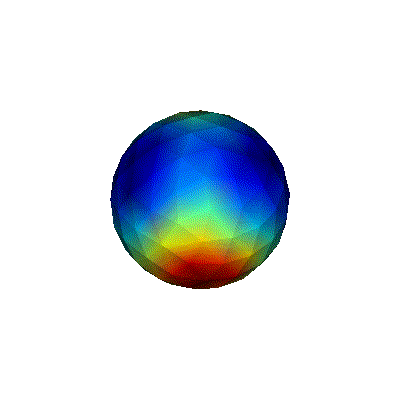

In [34]:
# we generate an antipodally symmetric spherical function from our signal
signal_sph = np.zeros(vertices.shape[0]*2)
signal_sph[0:vertices.shape[0]] = signal[1:-1]
signal_sph[vertices.shape[0]:] = signal[1:-1]

image = screenshot_animated_sf(signal_sph, sph_gtab, False, False, False, 
                               title="Simulated tensor with {} fiber(s), unscaled".format(N))
Image(filename=image)

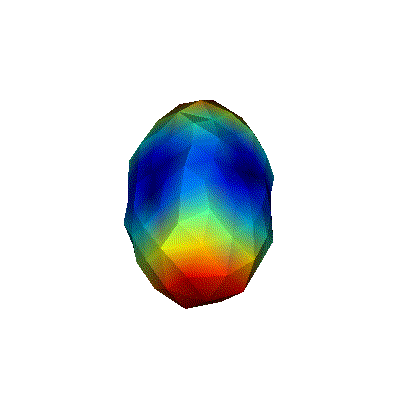

In [35]:
image = screenshot_animated_sf(signal_sph, sph_gtab, False, False, True,
                               title="Simulated tensor with {} fiber(s), scaled".format(N))
Image(filename=image)

For more, see Dipy gallery https://dipy.org/documentation/1.3.0./examples_built/simulate_multi_tensor/#example-simulate-multi-tensor


## Playing with the Apparent Diffusion Coefficient (ADC)

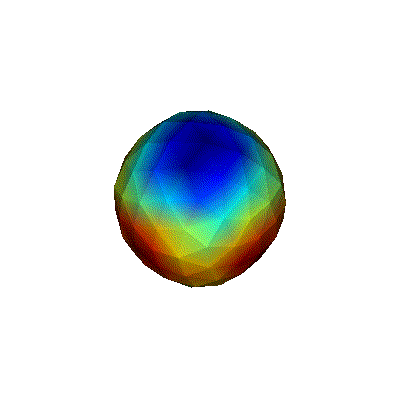

In [36]:
adc = -1/bvalue*np.log(signal_sph)

image = screenshot_animated_sf(adc, sph_gtab, True, True, True, title='ADC')
Image(filename=image)

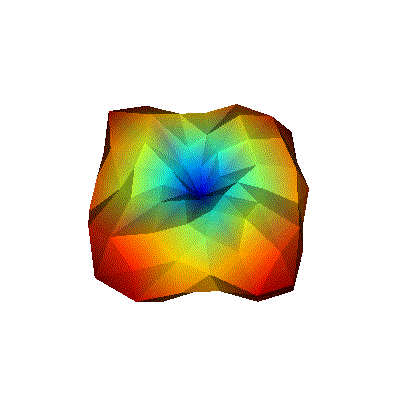

In [37]:
# min-max normalization to enhance the spherical values
adc = (adc - adc.min()) / (adc.max()-adc.min())

image = screenshot_animated_sf(adc, sph_gtab, True, True, True, title="ADC - min-max normalized")
Image(filename=image)

## Playing with spherical harmonics

In [38]:
from dipy.reconst.shm import sh_to_sf_matrix

print('Building SH matrix of order 2')
B, invB = sh_to_sf_matrix(sph_gtab, 2)
print('Shape: ', B.shape, '\n')
print('Building SH matrix of order 4')
B, invB = sh_to_sf_matrix(sph_gtab, 4)
print('Shape: ', B.shape, '\n')
print('Building SH matrix of order 8')
B, invB = sh_to_sf_matrix(sph_gtab, 8)
print('Shape:', B.shape, '\n')

print('Building high resolution SH matrix of order 8')
sphere = get_sphere('symmetric724')
sphere = sphere.subdivide(2)
B_highres, invB_highres = sh_to_sf_matrix(sphere, 8)
print('Shape: ', B_highres.shape)

Building SH matrix of order 2
Shape:  (6, 128) 

Building SH matrix of order 4
Shape:  (15, 128) 

Building SH matrix of order 8
Shape: (45, 128) 

Building high resolution SH matrix of order 8
Shape:  (45, 11554)


In [39]:
print('Estimate SH coefficients of the signal')
# S = B*sh_signal  => sh_signal = invB * S
sh_signal = np.dot(invB.T, signal_sph)
print('SH signal shape: ', sh_signal.shape, '\n')
print('Project back SH coefficient to the high resolution sphere')
signal_sphere = np.dot(sh_signal, B_highres)
print('SF signal shape: ', signal_sphere.shape)

Estimate SH coefficients of the signal
SH signal shape:  (45,) 

Project back SH coefficient to the high resolution sphere
SF signal shape:  (11554,)


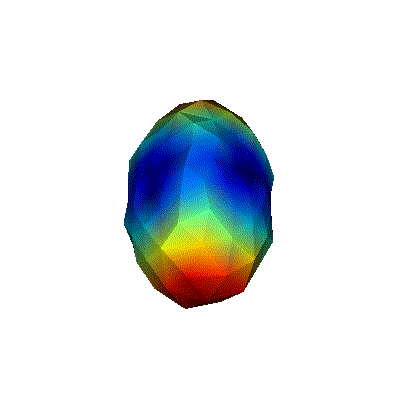

In [40]:
image = screenshot_animated_sf(signal_sph, sph_gtab, False,
                               title="Basic signal on the sphere")
Image(filename=image)

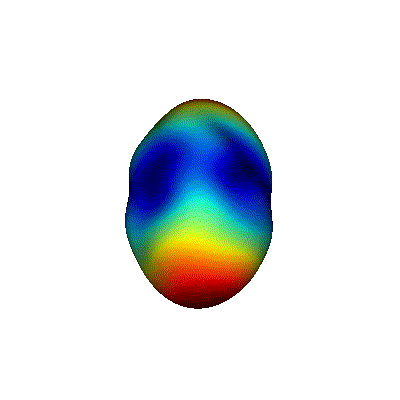

In [41]:
image = screenshot_animated_sf(signal_sphere, sphere, False,
                               title="SH backprojected on High-res sphere")
Image(filename=image)

In [42]:
print('SH coefficients up to order 8')
print(sh_signal)
print('\nSH approximation up to order 0')
sh0 = np.zeros(45)
sh0[0] = sh_signal[0]
signal_sphere = np.dot(sh0, B_highres)
print(sh0)

SH coefficients up to order 8
[ 1.72701556e+02 -2.19430840e+01  6.43302832e-03 -1.25191731e+01
 -4.05041893e-01  4.58086859e-01  2.38800015e+00  8.43395050e-02
 -2.06058712e+00  2.28249540e-01  4.28460774e+00 -1.00526838e-01
  4.35335082e-01  5.98958157e-01  5.18878563e-02 -9.82544343e-01
  4.51339652e-01  1.01743701e+00 -1.12556017e+00 -6.45934478e-01
 -5.06589552e-02  1.54043319e-01  6.08683520e-01 -1.83278774e-01
 -2.67352096e-01  7.25409921e-01 -1.19175830e-01 -9.32049484e-03
 -5.67184057e-01 -3.68450591e-01  2.21869238e-01  8.18746163e-01
  2.40824006e-01  7.86501794e-01 -3.56674770e-01  1.23691896e-01
 -2.95362841e-01 -7.02281819e-02 -8.13678985e-01  2.23370822e-01
 -7.11213127e-01 -2.66115263e-01  4.31852906e-01 -8.12076532e-01
 -1.80723971e-02]

SH approximation up to order 0
[172.7015558   0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.  

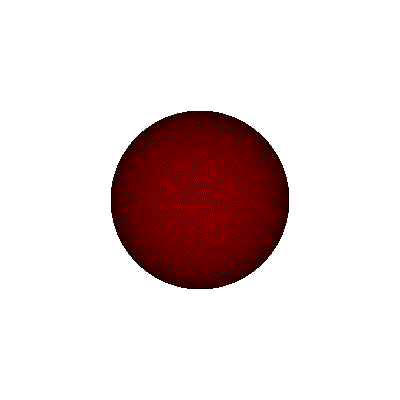

In [43]:
# Let's visualize our order 0 SH approximation
image = screenshot_animated_sf(signal_sphere, sphere, False,
                               title="Signal with SH order 0")
Image(filename=image)

In [44]:
sh2 = np.zeros(45)
sh2[0:6] = sh_signal[0:6]
print('SH coefficients up to order 2')
print(sh2)

SH coefficients up to order 2
[ 1.72701556e+02 -2.19430840e+01  6.43302832e-03 -1.25191731e+01
 -4.05041893e-01  4.58086859e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]


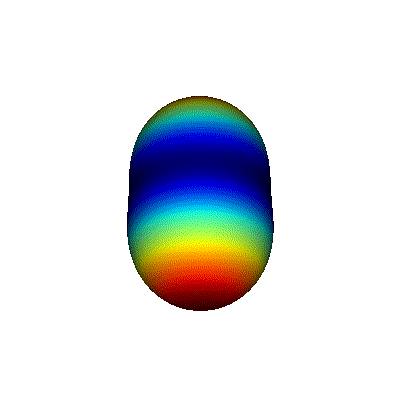

In [45]:
signal_sphere = np.dot(sh2, B_highres)

image = screenshot_animated_sf(signal_sphere, sphere, False,
                               title="Signal with SH order 2")
Image(filename=image)

In [46]:
sh4 = np.zeros(45)
sh4[0:15] = sh_signal[0:15]
print('SH approximation up to order 4')
print(sh4)


SH approximation up to order 4
[ 1.72701556e+02 -2.19430840e+01  6.43302832e-03 -1.25191731e+01
 -4.05041893e-01  4.58086859e-01  2.38800015e+00  8.43395050e-02
 -2.06058712e+00  2.28249540e-01  4.28460774e+00 -1.00526838e-01
  4.35335082e-01  5.98958157e-01  5.18878563e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]


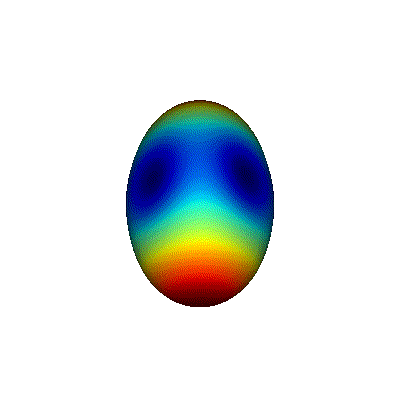

In [47]:
signal_sphere = np.dot(sh4, B_highres)

image = screenshot_animated_sf(signal_sphere, sphere, False,
                               title="Signal with SH order 4")
Image(filename=image)

Alternatively, `sh_to_sf` and `sf_to_sh` functions are cool!

In [48]:
from dipy.reconst.shm import sh_to_sf, sf_to_sh
print('SH signal:\n', sh_signal)
sf_signal = sh_to_sf(sh_signal, sph_gtab, 8)
print('SF signal:\n', sf_signal)
print('SF reconstruction error:', np.mean(np.abs(signal_sph - sf_signal)))

SH signal:
 [ 1.72701556e+02 -2.19430840e+01  6.43302832e-03 -1.25191731e+01
 -4.05041893e-01  4.58086859e-01  2.38800015e+00  8.43395050e-02
 -2.06058712e+00  2.28249540e-01  4.28460774e+00 -1.00526838e-01
  4.35335082e-01  5.98958157e-01  5.18878563e-02 -9.82544343e-01
  4.51339652e-01  1.01743701e+00 -1.12556017e+00 -6.45934478e-01
 -5.06589552e-02  1.54043319e-01  6.08683520e-01 -1.83278774e-01
 -2.67352096e-01  7.25409921e-01 -1.19175830e-01 -9.32049484e-03
 -5.67184057e-01 -3.68450591e-01  2.21869238e-01  8.18746163e-01
  2.40824006e-01  7.86501794e-01 -3.56674770e-01  1.23691896e-01
 -2.95362841e-01 -7.02281819e-02 -8.13678985e-01  2.23370822e-01
 -7.11213127e-01 -2.66115263e-01  4.31852906e-01 -8.12076532e-01
 -1.80723971e-02]
SF signal:
 [66.44996355 47.63744438 40.74196621 40.90745761 41.43575584 53.16046255
 62.82234945 44.01847711 42.22754193 48.19844352 43.49844272 47.2446484
 45.47478545 46.18821689 49.33341382 57.20153302 65.12245807 62.26094489
 52.59348528 41.61011942 

In [49]:
sh_signal2 = sf_to_sh(sf_signal, sph_gtab, sh_order=8)
print('SH signal (from SF):\n', sh_signal2)
print('SH reconstruction error:', np.mean(np.abs(sh_signal - sh_signal2)))

SH signal (from SF):
 [ 1.72701556e+02 -2.19430840e+01  6.43302832e-03 -1.25191731e+01
 -4.05041893e-01  4.58086859e-01  2.38800015e+00  8.43395050e-02
 -2.06058712e+00  2.28249540e-01  4.28460774e+00 -1.00526838e-01
  4.35335082e-01  5.98958157e-01  5.18878563e-02 -9.82544343e-01
  4.51339652e-01  1.01743701e+00 -1.12556017e+00 -6.45934478e-01
 -5.06589552e-02  1.54043319e-01  6.08683520e-01 -1.83278774e-01
 -2.67352096e-01  7.25409921e-01 -1.19175830e-01 -9.32049484e-03
 -5.67184057e-01 -3.68450591e-01  2.21869238e-01  8.18746163e-01
  2.40824006e-01  7.86501794e-01 -3.56674770e-01  1.23691896e-01
 -2.95362841e-01 -7.02281819e-02 -8.13678985e-01  2.23370822e-01
 -7.11213127e-01 -2.66115263e-01  4.31852906e-01 -8.12076532e-01
 -1.80723971e-02]
SH reconstruction error: 2.6418373661524835e-14


### Reconstruction of asymmetric signals using full SH bases
So far, we have only considered symmetric signal. However, even though the diffusion process is symmetric, it is possible for the fiber configuration at the voxel level to be asymmetric. Hence, the ability to represent asymmetric functions using SH is interesting. Let us simulate an asymmetric spherical function.

In [50]:
# utility functions to generate asymmetric SF using Kent distributions
from scipy.stats import halfnorm

def rotate_vector(v, k, a):
    kn = k/np.linalg.norm(k)
    # Rodrigues' rotation formula
    return v * np.cos(a) + np.cross(kn, v) * np.sin(a) + kn * np.dot(kn, v) * (1 - np.cos(a))

def single_kent(r, d):
    out_shape = r.shape[:r.ndim - 1]
    P = np.zeros(len(r))

    scale = np.linalg.norm(d)
    d = d / scale
    d_2 = np.array([d[1] - d[2], -d[0], d[0]])
    d_2 = d_2 / np.linalg.norm(d_2)

    rand_angle = np.random.rand() * 2 * np.pi
    d_2 = rotate_vector(d_2, d, rand_angle)

    d_3 = np.cross(d, d_2)

    b = np.clip(halfnorm.rvs(scale=0.05), 0., 0.3) * scale

    for (i, u) in enumerate(r):
        P[i] = np.exp(scale * np.dot(d, u) + b * (np.dot(d_2, u)**2 - np.dot(d_3, u)**2))
    return P.reshape(out_shape) / np.max(abs(P))
    
def generate_asym_sf(vertices, peaks, weights, noise_sig1=0, noise_sig2=0):
    sig = np.zeros(len(vertices))

    for peak, weight in zip(peaks, weights):
        sig +=  weight * single_kent(vertices, peak)

    if noise_sig1 != 0 or noise_sig2 != 0:
        sqrt2 = np.sqrt(2)
        noise1 = np.random.normal(0, noise_sig1, len(sig))
        noise2 = np.random.normal(0, noise_sig2, len(sig))
        
        sig = np.sqrt((sig + noise1 / sqrt2)**2 + (noise2 / sqrt2)**2)
    return sig

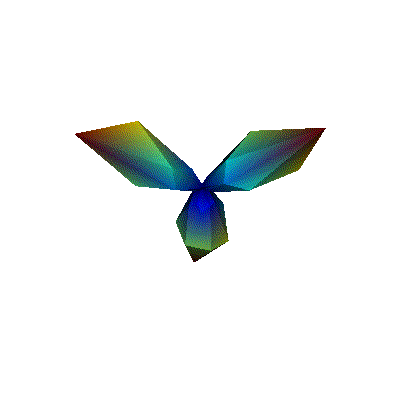

In [51]:
peaks = np.array([[10.0, 10.0, 0.0], [-10.0, 10.0, 0.0], [0.0, -10.0, 0.0]])
asym_sf = generate_asym_sf(sph_gtab.vertices, peaks, np.array([1.0, 1.0, 1.0]))

image = screenshot_animated_sf(asym_sf, sph_gtab, title='Asymmetric SF')
Image(filename=image)

In [52]:
sh_asym = sf_to_sh(asym_sf, sph_gtab, sh_order=8, full_basis=True)
print('Number of coefficients for SH order 8: ', len(sh_asym))

# Lets project it back on a high resolution sphere
sf_asym_hres = sh_to_sf(sh_asym, sphere, full_basis=True, sh_order=8)
print('Number of sphere directions for high res SF: ', len(sf_asym_hres)) 

Number of coefficients for SH order 8:  81
Number of sphere directions for high res SF:  11554


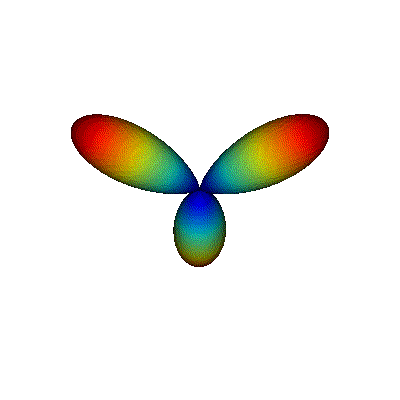

In [53]:
# Let's visualize it!
image = screenshot_animated_sf(sf_asym_hres, sphere, title='Asym reconstruction with SH order 8')
Image(filename=image)

# Part 2 - Orientation distribution functions
In this section, we transform our diffusion signal to an orientation distribution function (ODF).


## Playing with the diffusion ODF
First, the single and multi-tensor models have an analytical diffusion ODF solution. We reuse the `mevals`, `angles`, `fractions` and `sphere` variables defined before to generate a ground truth diffusion ODF (dODF).

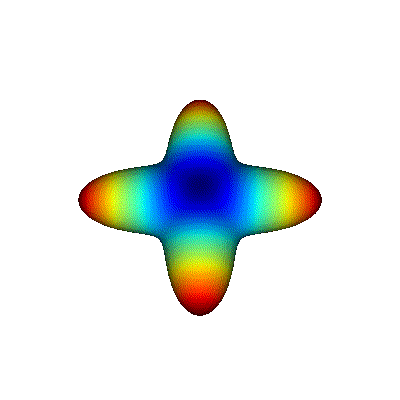

In [54]:
odf = multi_tensor_odf(sphere.vertices, mevals, angles, fractions)
image = screenshot_animated_sf(odf, sphere, title="Ground-truth population")
Image(filename=image)

### Q-ball model
We now attempt to reconstruct the dODF using a Q-ball model.

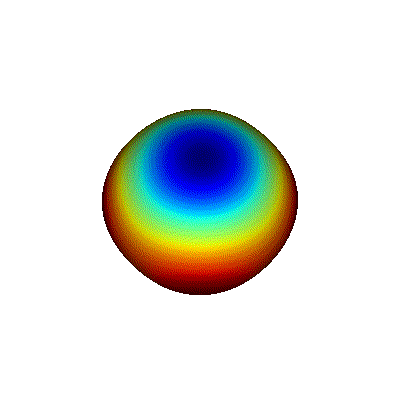

In [55]:
from dipy.reconst.shm import CsaOdfModel, QballModel
# qball model
qball_model = QballModel(gtab, 6)
fit = qball_model.fit(signal)
odf = fit.odf(sphere)

image = screenshot_animated_sf(odf, sphere,
                               title="Q-Ball model Orientation Probabilities")
Image(filename=image)

ODF min, max 0.4182653386218149 0.5411713885653107
ODF_MinMaxNormalized min, max 0.0 1.0
Qball GFA 0.07047139864501407


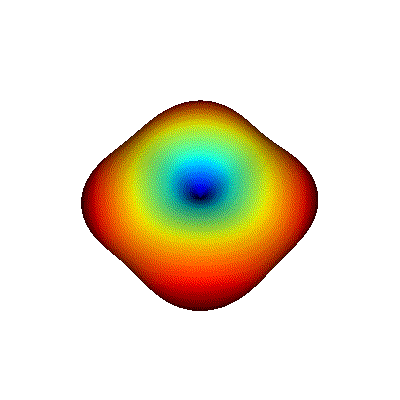

In [56]:
print('ODF min, max', odf.min(), odf.max())
odf = (odf - odf.min()) / (odf.max() - odf.min())
print('ODF_MinMaxNormalized min, max', odf.min(), odf.max())
print('Qball GFA', fit.gfa)

image = screenshot_animated_sf(odf, sphere, title="Q-Ball model Orientation Probabilities, normalized")
Image(filename=image)

The Q-ball diffusion ODF is not normalized and is a smoothed version of the *real* diffusion ODF.

### Constant Solid Angle reconstruction
CSA is always best with `sh_order` 4. Otherwise, it is too noisy in the high frequencies; regularization would be needed.


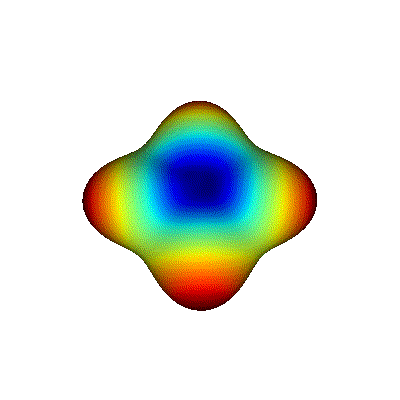

In [57]:
csa_model = CsaOdfModel(gtab, 4)
fit = csa_model.fit(signal)
odf = fit.odf(sphere)

image = screenshot_animated_sf(odf, sphere, title="CSA model Orientation Probabilities")
Image(filename=image)

ODF_MinMaxNormalized min, max 0.0 1.0
CSA-Qball GFA 0.3140162753567449


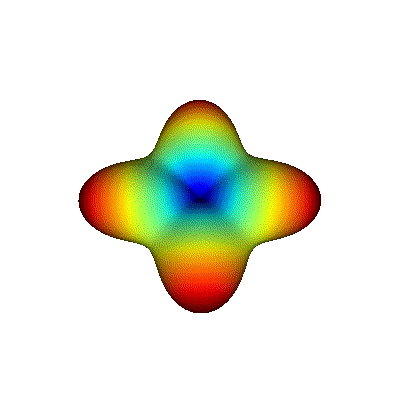

In [58]:
odf = (odf - odf.min()) / (odf.max() - odf.min())
print('ODF_MinMaxNormalized min, max', odf.min(), odf.max())
print('CSA-Qball GFA', fit.gfa)

image = screenshot_animated_sf(odf, sphere,
                               title="CSA model Orientation Probabilities, normalized")
Image(filename=image)

The CSA Q-ball diffusion ODF is normalized and a closer approximation to the _real_ dODF. However, it is vulnerable to noise and unstable for high SH order.

For more, see Dipy gallery https://dipy.org/documentation/1.3.0./examples_built/reconst_csa/#example-reconst-csa.

# Part 3 - Constrained spherical deconvolution
In this section, we will generate fiber ODFs (fODF) using constrained spherical deconvolution (CSD).

First, we need a response function to deconvolve. In real life, we estimate it from the data or we can fix it. See https://dipy.org/documentation/1.3.0./examples_built/reconst_csd/#example-reconst-csd. For this example, we will fix the fiber response function.

In [59]:
from dipy.reconst.csdeconv import ConstrainedSphericalDeconvModel

# Here, lets fix it and play with it.
response = (np.array([ 0.0015, 0.0004, 0.0004]), 1)
print('Signal:\n', signal)
print('Response function:\n', response)
# This is exactly the response that generated the synthetic signal. This is of course "cheating" a bit
# That is, a diffusion tensor [15,4,4] and mean normalized b0 signal 

# Then, we generate our fODF using CSD
csd_model = ConstrainedSphericalDeconvModel(gtab, response)
fit = csd_model.fit(signal)
fodf = fit.odf(sphere)

Signal:
 [99.04471301 65.86275858 47.41963206 41.05410963 41.09596241 41.08766722
 52.98670329 63.53322703 44.24637111 41.9492053  47.93610135 42.2654796
 47.77769728 45.10330913 45.70092668 49.02419416 57.13252659 65.44591114
 63.30594818 52.85633092 42.61034847 40.03423031 44.41995171 43.31335689
 55.06214008 51.16769279 42.87653646 41.44645007 59.46794559 44.65540143
 42.35866785 41.46569225 52.85763506 47.45860772 62.3297145  49.59638276
 41.69281232 43.55001499 39.14181882 48.1321783  49.15450279 54.32104837
 54.30061048 45.0023143  55.70842458 44.21831089 59.31620709 56.78928924
 53.75992115 43.53536194 41.73864808 61.4049515  38.9854624  48.57814539
 44.84982578 53.28619947 39.71669401 43.77897471 45.7466942  45.35356364
 49.71937056 47.35359745 50.60431692 62.77275773 38.47257142 99.42832819]
Response function:
 (array([0.0015, 0.0004, 0.0004]), 1)


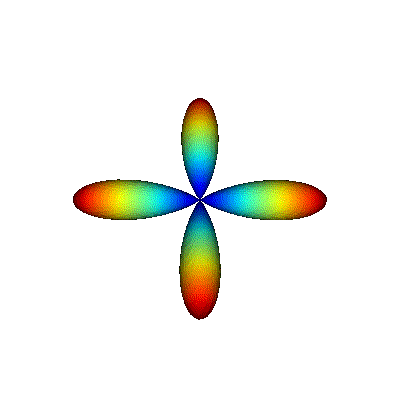

In [60]:
image = screenshot_animated_sf(fodf, sphere, title="CSD Model fiber Orientation Probabilities")
Image(filename=image)

In [61]:
from dipy.direction.peaks import peak_directions
directions, _, _ = peak_directions(fodf, sphere)
nufo = directions.shape[0]
print('Number of Fiber Orientations (NuFO):', nufo)

afd_total = fit.shm_coeff[0]
print('Total AFD:', afd_total)

Number of Fiber Orientations (NuFO): 2
Total AFD: 28.20396351060005


For more, see Dipy galleries https://dipy.org/documentation/1.3.0./examples_built/reconst_forecast/#example-reconst-forecast.